# US Census Data Classification Problem

Creating a model to predict if an instance (person) makes more than 50k from census results.

In [18]:
import numpy as np
import pandas as pd

import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

importing packages and pasting some useful methods 

In [19]:
def importData():
    train = pd.read_csv('./us_census_full/census_income_learn.csv')
    test = pd.read_csv('./us_census_full/census_income_test.csv')
    return train, test

def explore(data):
    summaryDf = pd.DataFrame(data.dtypes, columns=['dtypes'])
    summaryDf = summaryDf.reset_index()
    summaryDf['Name'] = summaryDf['index']
    summaryDf['Missing'] = data.isnull().sum().values
    summaryDf['Total'] = data.count().values
    summaryDf['MissPerc'] = (summaryDf['Missing']/summaryDf['Total'])*100
    summaryDf['NumUnique'] = data.nunique().values
    summaryDf['UniqueVals'] = [data[col].unique() for col in data.columns]
    print(summaryDf.head(50))


def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


def import_data(name):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv('us_census_full/' + name + '.csv', parse_dates=True, keep_date_col=True)
#     df = reduce_mem_usage(df)
    return df

def shapRanking(x_data, y_data):
    train_x, valid_x, train_y, valid_y = train_test_split(
        x_data, y_data, test_size=0.33, random_state=42)

    train_data = lgb.Dataset(train_x, label=train_y)
    valid_data = lgb.Dataset(valid_x, label=valid_y)

    # LGB parameters:
    params = {'learning_rate': 0.05,
              'boosting': 'gbdt',
              'objective': 'binary',
              'num_leaves': 2000,
              'min_data_in_leaf': 200,
              'max_bin': 200,
              'max_depth': 16,
              'seed': 2018,
              'nthread': 10, }

    # LGB training:
    lgb_model = lgb.train(params, train_data,
                          num_boost_round=2000,
                          valid_sets=(valid_data,),
                          verbose_eval=10,
                          early_stopping_rounds=20)

    explainer = shap.TreeExplainer(lgb_model).shap_values(valid_x)
    shap.summary_plot(explainer[1], valid_x)
    plt.show()

    shap.dependence_plot('Wage', explainer[1], valid_x)
    plt.show()

importing data and concatenating training and test sets

In [20]:
train = import_data('census_income_learn')
test = import_data('census_income_test')

# train_target = train['Target']
# train.drop(['Target'], axis=1, inplace=True)

# test_target = test['Target']
# test.drop(['Target'], axis=1, inplace=True)

train_len = train.shape[0]
test_len = test.shape[0]
df = pd.concat([train, test])

Defining separate industries based on age for those instances that have the wrong industry code (0 -> not in universe or children). Split those instances based on ages:
* A separate industry code for children
* One for pensioners
* One for those that are of working age but don't have an industry

In [21]:
#     df = df.replace([' Not in universe'], [None])
#     df = df.replace([' ?'], [None])
# not in universe or children in column IndustryCodeString - make the distinction, if age is <=16 therefore children
# else not in universe
df.drop(['IndustryCodeString', 'OccupationCodeString'], axis=1, inplace=True)
# children group
df.loc[(df['IndustryCode'] == 0) & (df['Age'] <= 18), 'IndustryCode'] = 52
# people not in any industry group
df.loc[(df['IndustryCode'] == 0) & (df['Age'] > 18) & (df['Age'] < 65), 'IndustryCode'] = 53
# old people group
df.loc[(df['IndustryCode'] == 0) & (df['Age'] >= 65), 'IndustryCode'] = 54

Latino is classed as being from (chicano is someone from mexico) cuba, mexico, puerto rico, 
south or central america, or other spanish culture or origin regardless of race. Therefore they are grouped here

In [22]:
df.loc[
    df['HispOrig'].isin([' Chicano', ' Cuban', ' Other Spanish', ' Puerto Rican', ' Central or South American', ' Mexican (Mexicano)', ' Other Spanish']),
    'HispOrig'
] = ' Latino'

df.loc[df['HispOrig']==' Do not know', 'HispOrig'] = ' NA'

Education field here is the highest level of education that a person has. They are grouped based on if high school was completed or not etc.

In [23]:
df.loc[
    (df['Education'].isin(
    [' 7th and 8th grade', ' 10th grade', ' 11th grade', ' 9th grade', ' 12th grade no diploma']
)) & (df['Age'] > 18), 'Education'
] = ' High School Dropout'

df.loc[
    (df['Education'].isin(
    [' 7th and 8th grade', ' 10th grade', ' 11th grade', ' 9th grade', ' 12th grade no diploma']
)) & (df['Age'] <= 18), 'Education'
] = ' High School'

In [24]:
df.loc[(df['Education'].isin([' 5th or 6th grade', ' 1st 2nd 3rd or 4th grade'])) & (df['Age'] >= 12), 'Education'] = ' Elementary School Dropout'
df.loc[(df['Education'].isin([' 5th or 6th grade', ' 1st 2nd 3rd or 4th grade'])) & (df['Age'] < 12), 'Education'] = ' Elementary School'

In [25]:
df.loc[(df['Education'] == ' Less than 1st grade') & (df['Age'] > 7), 'Education'] = ' No Education'

Fixing spelling mistake

In [26]:
df.loc[df['HouseholdSummaryStat']==' Child under 18 ever married', 'HouseholdSummaryStat'] = ' Child under 18 never married'

This feature within metadata is defined as `live in house 1 year ago`, which is a Yes/No question. Therefore those instances having the value `Not in universe under 1 year old` are set to No.

In [27]:
df.loc[df['HouseLive1Yr']==' Not in universe under 1 year old', 'HouseLive1Yr'] = ' No'

When looking at LabourUnion feature across the target variable (for those that are not `Not in universe`), the answers seem to follow a different distribution.

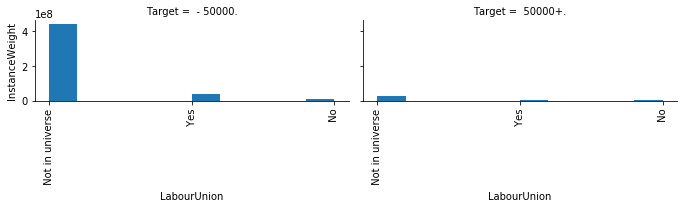

In [28]:
def weighted_hist(x, weights, **kwargs):
    plt.hist(x, weights=weights, **kwargs)
    plt.xticks(rotation=90)

grid = sns.FacetGrid(df, col='Target', aspect=1.6)
grid.map(weighted_hist, 'LabourUnion', 'InstanceWeight')
plt.show()

In [29]:
df.loc[(df['Target']==' - 50000.'), 'LabourUnion'].value_counts()

 Not in universe    255499
 No                  21356
 Yes                  3862
Name: LabourUnion, dtype: int64

In [30]:
df.loc[(df['Target']==' 50000+.'), 'LabourUnion'].value_counts()

 Not in universe    15243
 No                  2712
 Yes                  613
Name: LabourUnion, dtype: int64

Therefore, for those instances of working age (16 <= x <= 65) apply the same ratio based on target variables

In [31]:
df.loc[(df['LabourUnion']== ' Not in universe') & (df['Age'] < 16) & (df['Age'] > 65), 'LabourUnion'] = ' No'

In [32]:
lenNo = df.loc[(df['Target']==' - 50000.') & (df['LabourUnion']==' No')].shape[0]
lenTot = df.loc[(df['Target']==' - 50000.') & (df['LabourUnion']!=' Not in universe')].shape[0]
percNo = lenNo/lenTot

Take those not in universe, randomly sample the percentage that should be No according to class ratio, and then apply Yes to the rest

In [33]:
a = df.loc[(df['Target']==' - 50000.') & (df['LabourUnion']==' Not in universe'), 'LabourUnion']

In [34]:
df.loc[a.sample(frac=percNo).index, 'LabourUnion'] = ' No'

In [35]:
df.loc[(df['Target']==' - 50000.') & (df['LabourUnion']==' Not in universe'), 'LabourUnion'] = ' Yes'

Doing it now for positive class

In [36]:
lenNopos = df.loc[(df['Target']==' 50000+.') & (df['LabourUnion']==' No')].shape[0]
lenTotpos = df.loc[(df['Target']==' 50000+.') & (df['LabourUnion']!=' Not in universe')].shape[0]
percNopos = lenNopos/lenTotpos
percNopos

0.9692597831211692

In [37]:
b = df.loc[(df['Target']==' 50000+.') & (df['LabourUnion']==' Not in universe'), 'LabourUnion']
df.loc[b.sample(frac=percNopos).index, 'LabourUnion'] = ' No'
df.loc[(df['Target']==' 50000+.') & (df['LabourUnion']==' Not in universe'), 'LabourUnion'] = ' Yes'

Checking EducationLastWk, shouldn't matter as we have other education information. Due to the dataset containing a majority working portion and their respective educations being represented by the Education feature, this column was dropped.

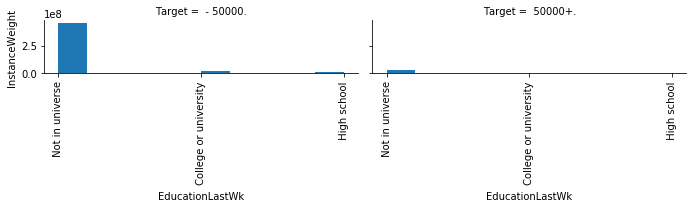

In [38]:
def weighted_hist(x, weights, **kwargs):
    plt.hist(x, weights=weights, **kwargs)
    plt.xticks(rotation=90)

grid = sns.FacetGrid(df, col='Target', aspect=1.6)
grid.map(weighted_hist, 'EducationLastWk', 'InstanceWeight')
plt.show()

In [39]:
df.drop('EducationLastWk', axis=1, inplace=True)

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


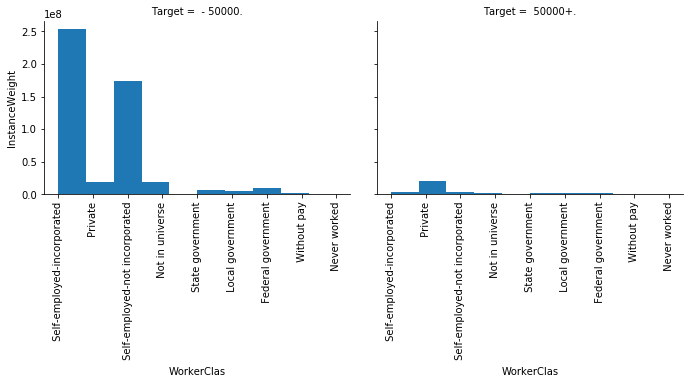

In [40]:
grid = sns.FacetGrid(df, col='Target', aspect=1.6)
grid.map(weighted_hist, 'WorkerClas', 'InstanceWeight')
plt.show()

Looking at the WorkerClas feature, the majority are `Not in universe`, with this most probably being the unemployed portion of the population.

In [41]:
df['WorkerClas'].value_counts()

 Not in universe                   150324
 Private                           108099
 Self-employed-not incorporated     12725
 Local government                   11617
 State government                    6394
 Self-employed-incorporated          4913
 Federal government                  4330
 Never worked                         643
 Without pay                          240
Name: WorkerClas, dtype: int64

Plotting the Age for those that are `Not in universe` for WorkerClas

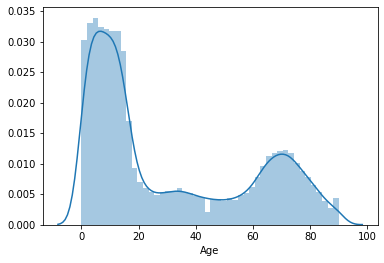

In [42]:
from scipy import stats
niuWCLen = df.loc[(df['WorkerClas']==' Not in universe')].shape[0]
avgAgeWCNIU = df.loc[df['WorkerClas']==' Not in universe', 'Age']

sns.distplot(avgAgeWCNIU)
plt.show()
# we can say that the not in universe for worker class are unemployed

In [43]:
# see age with respect to worker class
df.loc[df['Age'] < 18].WorkerClas.value_counts()

 Not in universe                   79624
 Private                            3274
 Never worked                        352
 Self-employed-not incorporated      202
 Local government                    131
 Self-employed-incorporated           54
 State government                     32
 Without pay                          28
 Federal government                   14
Name: WorkerClas, dtype: int64

In [44]:
df.loc[(df['WorkerClas']==' Not in universe'), 'WorkerClas'] = ' Unemployed'

In [45]:
df['WorkerClas'].value_counts()

 Unemployed                        150324
 Private                           108099
 Self-employed-not incorporated     12725
 Local government                   11617
 State government                    6394
 Self-employed-incorporated          4913
 Federal government                  4330
 Never worked                         643
 Without pay                          240
Name: WorkerClas, dtype: int64

Now looking at the UnempReas feature. For those instances that are `Not in universe`, this probably implies that they are employed. It was plotted against WeeksWorked to get an idea.

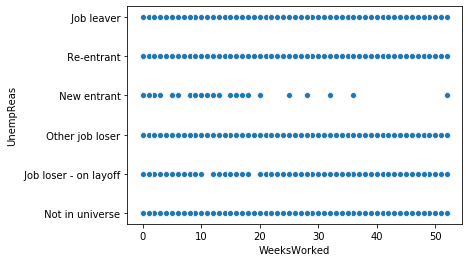

In [46]:
sns.scatterplot(y='UnempReas', x='WeeksWorked', data=df)
plt.show()

In [47]:
# assume that for unempreason not in universe means that they are employed
df.loc[df['UnempReas']==' Not in universe', 'UnempReas'] = ' Employed'

In [48]:
df['UnempReas'].value_counts()

 Employed                 290085
 Other job loser            3146
 Re-entrant                 3043
 Job loser - on layoff      1484
 Job leaver                  884
 New entrant                 643
Name: UnempReas, dtype: int64

Previous region being `Not in universe`, most probably implies that person hasn't moved from another region.

In [49]:
df['PrevReg'].value_counts()

 Not in universe    275818
 South                7314
 West                 6120
 Midwest              5273
 Northeast            4027
 Abroad                733
Name: PrevReg, dtype: int64

In [50]:
df.loc[df['PrevReg']==' Not in universe', 'PrevReg'] = ' No movement'

PrevReg could also be discarded since more information can be found in PrevState

In [51]:
df['PrevState'].value_counts()

 Not in universe    275818
 California           2598
 Utah                 1597
 Florida              1299
 North Carolina       1210
                     ...  
 Wisconsin             167
 South Carolina        144
 Delaware              121
 New Jersey            113
 Idaho                  45
Name: PrevState, Length: 51, dtype: int64

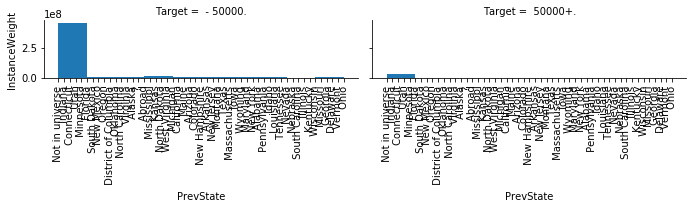

In [52]:
grid = sns.FacetGrid(df, col='Target', aspect=1.6)
grid.map(weighted_hist, 'PrevState', 'InstanceWeight')
plt.show()

For PrevState, there are missing values represented by `?`, which states are they?

In [53]:
# what is that ? value
allstates= np.array([
    ' Alabama',
    ' Alaska',
    ' Arizona',
    ' Arkansas',
    ' California',
    ' Colorado',
    ' Connecticut',
    ' Delaware',
    ' Florida',
    ' Georgia',
    ' Hawaii',
    ' Idaho',
    ' Illinois',
    ' Indiana',
    ' Iowa',
    ' Kansas',
    ' Kentucky',
    ' Louisiana',
    ' Maine',
    ' Maryland',
    ' Massachusetts',
    ' Michigan',
    ' Minnesota',
    ' Mississippi',
    ' Missouri',
    ' Montana',
    ' Nebraska',
    ' Nevada',
    ' New Hampshire',
    ' New Jersey',
    ' New Mexico',
    ' New York',
    ' North Carolina',
    ' North Dakota',
    ' Ohio',
    ' Oklahoma',
    ' Oregon',
    ' Pennsylvania',
    ' Rhode Island',
    ' South Carolina',
    ' South Dakota',
    ' Tennessee',
    ' Texas',
    ' Utah',
    ' Vermont',
    ' Virginia',
    ' Washington',
    ' West Virginia',
    ' Wisconsin',
    ' Wyoming',
    ' Abroad'
])
uniquePrevState = df['PrevState'].unique()
np.setdiff1d(allstates, uniquePrevState)

array([' Hawaii', ' Rhode Island', ' Washington'], dtype='<U15')

In [54]:
df['PrevState'].unique()

array([' Not in universe', ' Arkansas', ' Utah', ' Michigan',
       ' Minnesota', ' Alaska', ' Kansas', ' Indiana', ' ?',
       ' Massachusetts', ' New Mexico', ' Nevada', ' Tennessee',
       ' Colorado', ' Abroad', ' Kentucky', ' California', ' Arizona',
       ' North Carolina', ' Connecticut', ' Florida', ' Vermont',
       ' Maryland', ' Oklahoma', ' Oregon', ' Ohio', ' South Carolina',
       ' Texas', ' Montana', ' Wyoming', ' Georgia', ' Pennsylvania',
       ' Iowa', ' New Hampshire', ' Missouri', ' Alabama',
       ' North Dakota', ' New Jersey', ' Louisiana', ' West Virginia',
       ' Delaware', ' Illinois', ' Maine', ' Wisconsin', ' New York',
       ' Idaho', ' District of Columbia', ' South Dakota', ' Nebraska',
       ' Virginia', ' Mississippi'], dtype=object)

Adding not mentioned states by looking at previous region and checking states that are not in the `value_counts()`. (Hawaii not included)

In [55]:
# see proportion of ? compared to overall length
df.loc[df['PrevState']==' ?'].shape[0]/df.shape[0]
# around 0.3%

# US pop in 1995 was 266.6 million (1995)
# washington population 1995 was 5.431 million 
# set ? to washington
df.loc[df['PrevState']==' ?'].PrevReg.value_counts()
# prevreg has northeast - rhode island and south - washington

df.loc[(df['PrevState']==' ?') & (df['PrevReg']==' Northeast'), 'PrevState'] = ' Rhode Island'
df.loc[(df['PrevState']==' ?') & (df['PrevReg']==' South'), 'PrevState'] = ' Washington'

Over 42 million Americans
moved in the 1-year period
between March 1992 and
March 1993. This amounted
to 16.8 percent of the population 1 year old and over.
 Most movers stay in the
same county. In fact, about
two-thirds of the movers
between March 1992 and
March 1993 (10.5 percent
of the total population)
made such a “local” move.
 The “average American”
makes 11.7 moves in a life

From: https://www.census.gov/prod/1/pop/profile/95/p23-189.pdf

Where not in universe, this probably means a person has not moved state. Also follows the same ratio seen in PrevReg.

In [56]:
df.loc[df['PrevState']==' Not in universe', 'PrevState'] = ' Same state'

In [57]:
df.MigCodeMSA.value_counts()

 ?                   149642
 Nonmover            123937
 MSA to MSA           15890
 NonMSA to nonMSA      4155
 Not in universe       2239
 MSA to nonMSA         1154
 NonMSA to MSA          910
 Not identifiable       630
 Abroad to MSA          619
 Abroad to nonMSA       109
Name: MigCodeMSA, dtype: int64

Going by ratio of non-movers, `?` in MigCodeMSA can also be set to `Nonmover`. Same was done for MigCodeRegDiff and MigCodeRegSame

In [58]:
# seems like the question marks here imply that there was no movement
df.loc[df['MigCodeMSA'] == ' ?'].PrevState.value_counts()
df.loc[df['MigCodeMSA'] == ' ?', 'MigCodeMSA'] = ' Nonmover'

In [59]:
df['MigCodeRegDiff'].value_counts()
df.loc[df['MigCodeRegDiff']==' ?', 'MigCodeRegDiff'] = ' Nonmover'

In [60]:
df.loc[df['MigCodeRegSame']== ' ?', 'MigCodeRegSame'] = ' Nonmover'

In [61]:
df['MigCodeMSA'].value_counts()

 Nonmover            273579
 MSA to MSA           15890
 NonMSA to nonMSA      4155
 Not in universe       2239
 MSA to nonMSA         1154
 NonMSA to MSA          910
 Not identifiable       630
 Abroad to MSA          619
 Abroad to nonMSA       109
Name: MigCodeMSA, dtype: int64

In [62]:
df.loc[df['MigCodeMSA']==' Not in universe'].TaxFilerStat.value_counts()

 Nonfiler                        2237
 Joint both under 65                1
 Joint one under 65 & one 65+       1
Name: TaxFilerStat, dtype: int64

In [63]:
# migcodemsa - age is 0 for all, therefore set as nonmover
df.loc[df['MigCodeMSA']==' Not in universe', 'MigCodeMSA'] = ' Nonmover'
df.loc[df['MigCodeRegDiff']==' Not in universe', 'MigCodeRegDiff'] = ' Nonmover'
df.loc[df['MigCodeRegSame']==' Not in universe', 'MigCodeRegSame'] = ' Nonmover'

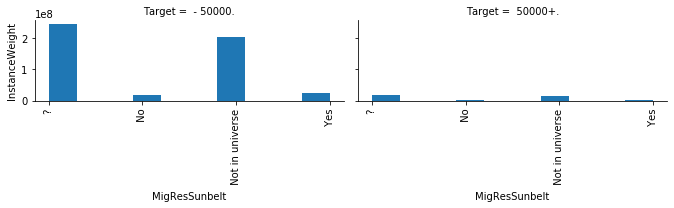

In [64]:
df['MigResSunbelt'].value_counts()

grid = sns.FacetGrid(df, col='Target', aspect=1.6)
grid.map(weighted_hist, 'MigResSunbelt', 'InstanceWeight')
plt.show()

In [65]:
df.loc[(df['Target']==' - 50000.'),'MigResSunbelt'].value_counts()

 ?                  139772
 Not in universe    118425
 No                  14146
 Yes                  8374
Name: MigResSunbelt, dtype: int64

In [66]:
df.loc[(df['Target']==' 50000+.'),'MigResSunbelt'].value_counts()

 ?                  9870
 Not in universe    7751
 No                  652
 Yes                 295
Name: MigResSunbelt, dtype: int64

In [67]:
# df.loc[(df['Target']==' 50000+.') & (df['MigResSunbelt']==' ?'), 'MigCodeMSA'].value_counts()
df.loc[(df['MigResSunbelt']==' ?'), 'MigResSunbelt'].value_counts()

 ?    149642
Name: MigResSunbelt, dtype: int64

Can't find any info regarding migressunbelt... dropping

In [68]:
df.drop('MigResSunbelt', axis=1, inplace=True)

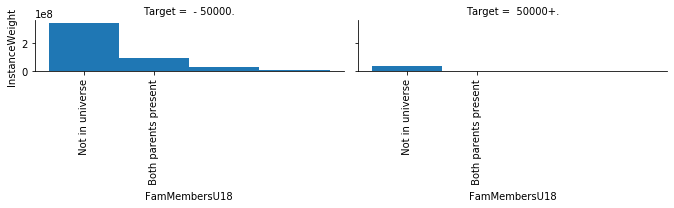

In [69]:
grid = sns.FacetGrid(df, col='Target', aspect=1.6)
grid.map(weighted_hist, 'FamMembersU18', 'InstanceWeight', bins=np.arange(0,df['FamMembersU18'].nunique())-0.5)
plt.show()

Same with FamMembersU18

In [70]:
df.loc[(df['FamMembersU18']==' Not in universe')]
df.drop('FamMembersU18', axis=1, inplace=True)

For birth countries, the most popular value count was picked for `?` entries

In [71]:
df.loc[df['FatherBirthCountry']==' ?', 'FatherBirthCountry'] = df['FatherBirthCountry'].value_counts().keys()[0]
df.loc[df['MotherBirthCountry']==' ?', 'MotherBirthCountry'] = df['MotherBirthCountry'].value_counts().keys()[0]
df.loc[df['SelfBirthCountry']==' ?', 'SelfBirthCountry'] = df['SelfBirthCountry'].value_counts().keys()[0]

In [72]:
df['VeteranAdmQ'].value_counts()

 Not in universe    296274
 No                   2421
 Yes                   590
Name: VeteranAdmQ, dtype: int64

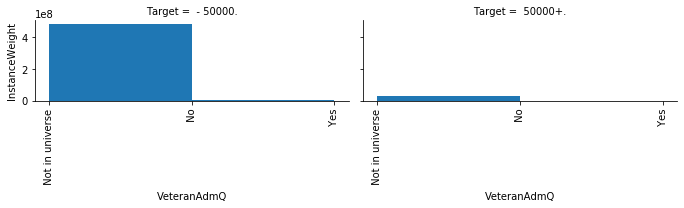

In [73]:
grid = sns.FacetGrid(df, col='Target', aspect=1.6)
grid.map(weighted_hist, 'VeteranAdmQ', 'InstanceWeight', bins=[0,1,2])
plt.show()

Assuming that not in universe here means that they are not veterans

In [74]:
df.loc[df['VeteranAdmQ']==' Not in universe', 'VeteranAdmQ'] = ' Not veteran'

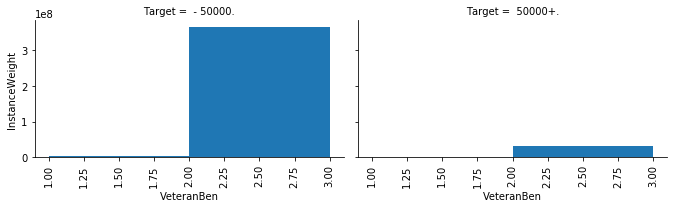

In [75]:
grid = sns.FacetGrid(df, col='Target', aspect=1.6)
grid.map(weighted_hist, 'VeteranBen', 'InstanceWeight', bins=[1,2,3])
plt.show()

In [76]:
# checking to make sure got rid of all
for col in df.columns:
    if (' Not in universe' in df[col].value_counts().keys()) or (' ?' in df[col].value_counts().keys()):
        print(col)

# Encoding Part

In [77]:
from sklearn.preprocessing import LabelEncoder

def convertFeatures(data):
    for col in data.columns.values:
        if data[col].dtype.name == 'object':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])

In [78]:
convertFeatures(df)

There is a large proportion of 0s in the Wage column, which should be quite important for classification

In [79]:
df.loc[df['Wage']==0, 'Wage'] = None

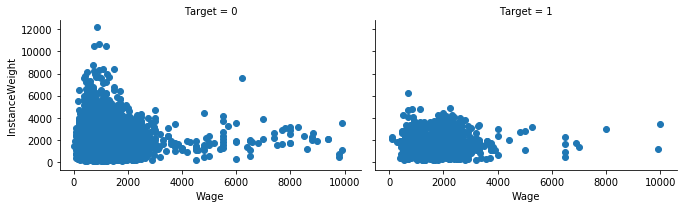

In [80]:
grid = sns.FacetGrid(df, col='Target', aspect=1.6)
grid.map(plt.scatter, 'Wage', 'InstanceWeight')
plt.show()

In [81]:
df['Wage'].describe()

count    16888.000000
mean       976.557793
std        651.346665
min         20.000000
25%        580.000000
50%        800.000000
75%       1200.000000
max       9999.000000
Name: Wage, dtype: float64

ShapRanking was done for the entries within the data where Wage is not 0. This shows that Wage is the most important feature.


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 20 rounds
[10]	valid_0's binary_logloss: 0.155915
[20]	valid_0's binary_logloss: 0.145046
[30]	valid_0's binary_logloss: 0.139453
[40]	valid_0's binary_logloss: 0.135833
[50]	valid_0's binary_logloss: 0.13357
[60]	valid_0's binary_logloss: 0.132153
[70]	valid_0's binary_logloss: 0.131216
[80]	valid_0's binary_logloss: 0.131238
[90]	valid_0's binary_logloss: 0.13157
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.131184


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


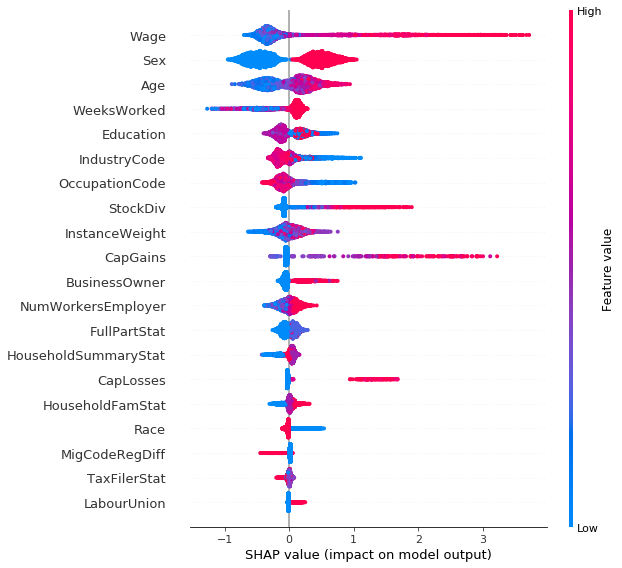

In [82]:
# what is most important to my wage feature
# do shapley ranking of wage 
def shapRanking(x_data, y_data):
    train_x, valid_x, train_y, valid_y = train_test_split(
        x_data, y_data, test_size=0.33, random_state=42)

    train_data = lgb.Dataset(train_x, label=train_y)
    valid_data = lgb.Dataset(valid_x, label=valid_y)

    # LGB parameters:
    params = {'learning_rate': 0.05,
              'boosting': 'gbdt',
              'objective': 'binary',
              'num_leaves': 2000,
              'min_data_in_leaf': 200,
              'max_bin': 200,
              'max_depth': 16,
              'seed': 2018,
              'nthread': 10, }

    # LGB training:
    lgb_model = lgb.train(params, train_data,
                          num_boost_round=2000,
                          valid_sets=(valid_data,),
                          verbose_eval=10,
                          early_stopping_rounds=20)

    explainer = shap.TreeExplainer(lgb_model).shap_values(valid_x)
    shap.summary_plot(explainer[1], valid_x)
    plt.show()
    
# wage_df = df.drop(['Wage', 'InstanceWeight'], axis=1).loc[df['Wage']!=np.nan]
wage_df = df.loc[df['Wage'].notnull()]
wage_df_y = wage_df['Wage']

# just checking what is important to target when wage is not 0
wage_df_target = wage_df['Target']

wage_df.drop('Target', inplace=True, axis=1)

shapRanking(wage_df, wage_df_target)
# shows that wage is important when it is there
# try knn for wages when 0

wage_df.drop(['Wage'], inplace=True, axis=1)

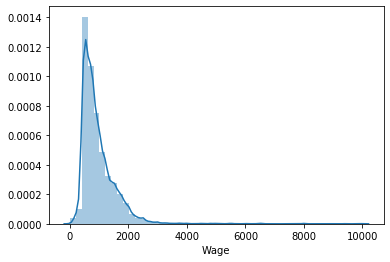

In [83]:
sns.distplot(df.loc[df['Wage'].notnull()]['Wage'])

In [84]:
from scipy import stats

# wage_list = df.loc[df['Wage'].notnull()]['Wage']
# stats.probplot(wage_list, plot=sns.mpl.pyplot)
wage_series = df.loc[df['Wage'].notnull()]['Wage'].value_counts()
# 16888 have a wage
# median is 2, mean is around 11.8
wage_series

500.0     1094
600.0      831
700.0      815
800.0      756
1000.0     599
          ... 
7800.0       1
270.0        1
1659.0       1
2085.0       1
1301.0       1
Name: Wage, Length: 1424, dtype: int64

Some 0 Wages were filled in by grouping the data according to IndustryCode, Education and OccupationCode and taking the mean of the wage.

In [85]:
df['Wage'] = df['Wage'].transform(lambda x: x.fillna(0))
df['Wage'] = df.groupby(['IndustryCode', 'Education', 'OccupationCode'])['Wage'].transform(lambda x: x.fillna(x.mean()))

# df.loc[df['Wage']==0].shape

In [86]:
df.loc[df['Wage']==0, 'Wage'] = None

When no mean could be found for the given groupby, the same was done but this time grouping by Education and OccupationCode.

In [87]:
df['Wage'] = df.groupby(['Education', 'OccupationCode'])['Wage'].transform(lambda x: x.fillna(x.mean()))

The left over 0 Wages were dealt with using a KNN imputation method. The 95th percentile in terms of wage (0-2000) were taken as training points.

In [88]:
# from sklearn.impute import KNNImputer

df.loc[df['Wage'].isnull(), 'Wage'] = 0
df_ninetyfifth = df.loc[df['Wage'] < df['Wage'].quantile(0.95)]

#  using groupby averages (ie filled in) to train knn and fill in others where 0
df_ninetyfifth_wage = df_ninetyfifth.loc[df_ninetyfifth['Wage']!=0]
df_ninetyfifth_wage

,Age,WorkerClas,IndustryCode,OccupationCode,Education,Wage,MaritalStat,Race,HispOrig,Sex,LabourUnion,UnempReas,FullPartStat,CapGains,CapLosses,StockDiv,TaxFilerStat,PrevReg,PrevState,HouseholdFamStat,HouseholdSummaryStat,InstanceWeight,MigCodeMSA,MigCodeRegDiff,MigCodeRegSame,HouseLive1Yr,NumWorkersEmployer,FatherBirthCountry,MotherBirthCountry,SelfBirthCountry,Cit,BusinessOwner,VeteranAdmQ,VeteranBen,WeeksWorked,Yr,Target
1,58,5,4,34,12,1375.619718,0,4,0,1,0,0,0,0,0,0,0,4,4,20,3,1053.55,2,6,7,0,1,39,39,39,4,0,1,2,52,94,0
5,48,3,40,10,12,1200.000000,2,0,0,0,0,0,1,0,0,0,2,2,40,37,6,162.61,6,5,6,0,1,30,39,39,4,2,1,2,52,95,0
6,42,3,34,3,2,1344.528090,2,4,0,1,0,0,0,5178,0,0,2,2,40,20,3,1535.86,6,5,6,1,6,39,39,39,4,0,1,2,52,94,0
7,28,3,4,40,8,965.727273,4,4,0,0,0,2,6,0,0,0,5,2,40,35,4,898.83,6,5,6,0,4,39,39,39,4,0,1,2,30,95,0
8,47,1,43,26,12,876.000000,2,4,0,0,0,0,1,0,0,0,2,2,40,37,6,1661.53,6,5,6,0,5,39,39,39,4,0,1,2,52,95,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99752,46,3,44,3,12,1028.965517,2,2,0,0,0,0,1,0,0,0,2,2,40,37,6,1197.34,6,5,6,0,1,39,39,39,4,0,1,2,52,95,0
99754,17,3,33,29,6,451.438525,4,4,0,0,0,0,1,0,0,0,4,2,40,8,1,1414.11,6,5,6,0,6,39,39,39,4,0,1,2,1,95,0
99758,61,3,8,36,7,819.096000,5,2,0,1,0,0,1,0,0,0,5,2,40,22,3,2511.11,6,5,6,0,4,39,39,39,4,0,1,2,52,95,0
99759,24,5,1,43,7,475.000000,2,4,1,1,0,0,0,0,0,0,2,2,40,36,4,2083.76,6,5,6,1,2,25,25,25,1,0,1,2,52,94,0


In [89]:
from sklearn.neighbors import KNeighborsRegressor

df_ninetyfifth_wage_y = df_ninetyfifth_wage['Wage']
df_ninetyfifth_wage.drop(['InstanceWeight', 'Wage', 'Target'], axis=1, inplace=True)

# fit knn regressor on data that has wage (orig + groupby)
neig = KNeighborsRegressor(n_neighbors=10)
neig.fit(df_ninetyfifth_wage, df_ninetyfifth_wage_y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [90]:
df.loc[df['Wage']==0, 'Wage'] = neig.predict(df.loc[df['Wage']==0].drop(['InstanceWeight', 'Wage', 'Target'], axis=1))

After predicting via KNN, set those that are out of working age to 0 Wage. Also those that are unemployed as having 0 Wage

In [91]:
# set all those that arent of working age to have 0 wage
df.loc[(df['Age'] > 16) & (df['Age'] <= 65), 'Wage'] = 0

# not employed therefore should have 0 wage
df.loc[(df['UnempReas']!=0), 'Wage'] = 0

In [92]:
df['UnempReas'].value_counts()

0    290085
4      3146
5      3043
2      1484
1       884
3       643
Name: UnempReas, dtype: int64

Shap ranking done over all data shows how the newly imputed wage has made the feature more important (when compared to previous implementation in other repo).

Training until validation scores don't improve for 20 rounds
[10]	valid_0's binary_logloss: 0.16016
[20]	valid_0's binary_logloss: 0.139326
[30]	valid_0's binary_logloss: 0.128829
[40]	valid_0's binary_logloss: 0.122855
[50]	valid_0's binary_logloss: 0.118989
[60]	valid_0's binary_logloss: 0.116616
[70]	valid_0's binary_logloss: 0.115057
[80]	valid_0's binary_logloss: 0.11397
[90]	valid_0's binary_logloss: 0.113291
[100]	valid_0's binary_logloss: 0.112722
[110]	valid_0's binary_logloss: 0.112359
[120]	valid_0's binary_logloss: 0.112053
[130]	valid_0's binary_logloss: 0.111681
[140]	valid_0's binary_logloss: 0.111371
[150]	valid_0's binary_logloss: 0.111169
[160]	valid_0's binary_logloss: 0.110953
[170]	valid_0's binary_logloss: 0.110758
[180]	valid_0's binary_logloss: 0.110606
[190]	valid_0's binary_logloss: 0.110493
[200]	valid_0's binary_logloss: 0.110414
[210]	valid_0's binary_logloss: 0.110334
[220]	valid_0's binary_logloss: 0.110267
[230]	valid_0's binary_logloss: 0.1102
[240]	val

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


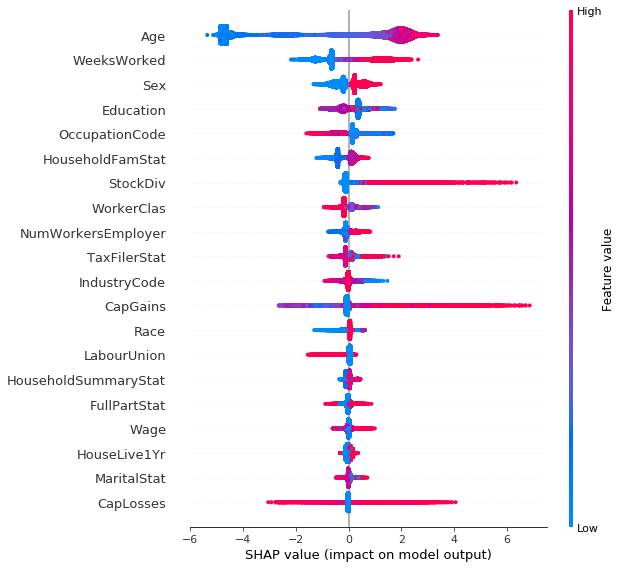

In [93]:
df_new_y = df['Target']
df_new = df.drop(['Target', 'InstanceWeight'], axis=1)
shapRanking(df_new, df_new_y)

# Feature Ranking

In [94]:
df_rank_test = df.drop(['InstanceWeight'], axis=1)
df_rank_test_y = df_rank_test['Target']
df_rank_test.drop(['Target'], axis=1, inplace=True)

In [95]:
from sklearn.feature_selection import RFE, SelectKBest, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
def recursiveFeatureElim(x_data, y_data):
    # using recursive feature elimination
    estimator = LogisticRegression(solver='lbfgs')
    selector = RFE(estimator, 10, step=1)
    selector = selector.fit(x_data, y_data)
    print(selector.ranking_)
    print(x_data.columns.values)
    print(selector.n_features_)    
    
recursiveFeatureElim(df_rank_test, df_rank_test_y)

NameError: name 'LogisticRegression' is not defined

In [ ]:
def chiSquare(x_data, y_data):
    # using chisquare test - only for categorical vars, higher implies greater independence
    chiData = x_data.drop(['Age', 'Wage', 'CapGains', 'CapLosses', 'StockDiv', 'NumWorkersEmployer', 'WeeksWorked'], axis=1)
    selector = SelectKBest(score_func=chi2, k='all')
    selector.fit(chiData, y_data)
    fs_res = selector.transform(chiData)
    for i in range(len(selector.scores_)):
        print('Feature %s: %f' % (chiData.columns.values[i], selector.scores_[i]))

    bar = plt.bar([i for i in range(len(selector.scores_))], selector.scores_, log=True)
    plt.xticks(ticks=np.arange(len(chiData.columns.values)), labels=chiData.columns.values, rotation=90)
    plt.show()
    
chiSquare(df_rank_test, df_rank_test_y)

In [ ]:
def mutualInfoRanking(x_data, y_data):
    # using mutual information feature selection
    selector = SelectKBest(score_func=mutual_info_classif, k='all')
    selector.fit(x_data, y_data)
    selector.transform(x_data)
    for i in range(len(selector.scores_)):
        print('Feature %s: %f' % (x_data.columns.values[i], selector.scores_[i]))

    bar = plt.bar([i for i in range(len(selector.scores_))], selector.scores_)
    plt.xticks(ticks=np.arange(len(x_data.columns.values)), labels=x_data.columns.values, rotation=90)
    plt.show()
    
mutualInfoRanking(df_rank_test, df_rank_test_y)

In [ ]:
def continuousCorrelation(data):
    data = data[['Age', 'Wage', 'CapGains', 'CapLosses', 'StockDiv', 'NumWorkersEmployer', 'WeeksWorked', 'Target']]
    corr = data.corr()
    hm = sns.heatmap(corr, vmin=-1, vmax=1, center=0, square=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
    plt.show()
    
continuousCorrelation(pd.concat([df_rank_test, df_rank_test_y], axis=1))

# Modelling Portion 

Simple model creation, one Logistic Regression and a LightGBM implementation. This produced the best accuracy(95.82 %)/auc score (95%).

In [ ]:
df.drop(['InstanceWeight'], axis=1, inplace=True)

In [ ]:
train = df[0:train_len]
test = df[train_len:(train_len + test_len)]

In [ ]:
train_y = train['Target']
train.drop(['Target'], axis=1, inplace=True)
test_y = test['Target']
test.drop(['Target'], axis=1, inplace=True)

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [ ]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
reg = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=500, random_state=123)
cross_val_score(reg, train, train_y, cv=kf)
preds = cross_val_predict(reg, test, test_y, cv=kf)
print('Accuracy Logistic Reg: ', (accuracy_score(preds, test_y)) * 100)
print('AOC ROC ', roc_auc_score(test_y.values, cross_val_predict(reg, test, test_y, cv=kf, method='predict_proba')[:,1]))

In [ ]:
import lightgbm as lgb

def lightGBMModel(x_data, y_data, x_test, y_test):
    # using lightgbm model to compare accuracy with normal rand forest
    train_x, valid_x, train_y, valid_y = train_test_split(
        x_data, y_data, test_size=0.33)

    train_data = lgb.Dataset(train_x, label=train_y)
    valid_data = lgb.Dataset(valid_x, label=valid_y)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
#         'metric': {'l2', 'l1'},
        'metric': 'auc',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'max_depth': 28,
        'num_estimators': 800
    }

    print('Starting training...')
    # train
    gbm = lgb.train(params,
                    train_data,
                    num_boost_round=2000,
                    valid_sets=valid_data,
                    early_stopping_rounds=50)

    print('Starting predicting...')
    # predict
    y_prob = gbm.predict(x_test.values, num_iteration=gbm.best_iteration)
    y_pred = [round(x) for x in y_prob]
    print('Accuracy LGBM: ', (accuracy_score(y_pred, y_test)) * 100)
    print('AOC ROC ', roc_auc_score(y_test.values, y_prob))

In [ ]:
lightGBMModel(train, train_y, test, test_y)